In [1]:
!pip3 install xgboost

In [2]:
#import packages for data manipulations
import pandas as pd
import numpy as np

#import packages for data visualization

import seaborn as sns
import matplotlib.pyplot as plt

# import packages for data preprocessing
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.utils import resample

# import packages for data modeling
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay,\
recall_score,precision_score,f1_score,accuracy_score

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier, plot_importance

# Data Load : Load the Videos information into dataframe

In [3]:
data = pd.read_csv("E:/Google Analytics/tiktok.csv")

data.head()

,#,claim_status,video_id,video_duration_sec,video_transcription_text,verified_status,author_ban_status,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count
0,1,claim,7017666017,59,someone shared with me that drone deliveries a...,not verified,under review,343296.0,19425.0,241.0,1.0,0.0
1,2,claim,4014381136,32,someone shared with me that there are more mic...,not verified,active,140877.0,77355.0,19034.0,1161.0,684.0
2,3,claim,9859838091,31,someone shared with me that american industria...,not verified,active,902185.0,97690.0,2858.0,833.0,329.0
3,4,claim,1866847991,25,someone shared with me that the metro of st. p...,not verified,active,437506.0,239954.0,34812.0,1234.0,584.0
4,5,claim,7105231098,19,someone shared with me that the number of busi...,not verified,active,56167.0,34987.0,4110.0,547.0,152.0


In [4]:
data.shape

(19382, 12)

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19382 entries, 0 to 19381
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   #                         19382 non-null  int64  
 1   claim_status              19084 non-null  object 
 2   video_id                  19382 non-null  int64  
 3   video_duration_sec        19382 non-null  int64  
 4   video_transcription_text  19084 non-null  object 
 5   verified_status           19382 non-null  object 
 6   author_ban_status         19382 non-null  object 
 7   video_view_count          19084 non-null  float64
 8   video_like_count          19084 non-null  float64
 9   video_share_count         19084 non-null  float64
 10  video_download_count      19084 non-null  float64
 11  video_comment_count       19084 non-null  float64
dtypes: float64(5), int64(3), object(4)
memory usage: 1.8+ MB


# Data Cleaning: Handing NA and Remove Duplicate Values

In [6]:
data.isnull().sum()

#                             0
claim_status                298
video_id                      0
video_duration_sec            0
video_transcription_text    298
verified_status               0
author_ban_status             0
video_view_count            298
video_like_count            298
video_share_count           298
video_download_count        298
video_comment_count         298
dtype: int64

As we see for six columns ,there are 298 null values present. 

Number of null values is very less compare to original size of data so we can remove all those line as part of EDA.

In [7]:
data = data.dropna(axis=0)

In [8]:
data.isnull().sum()

#                           0
claim_status                0
video_id                    0
video_duration_sec          0
video_transcription_text    0
verified_status             0
author_ban_status           0
video_view_count            0
video_like_count            0
video_share_count           0
video_download_count        0
video_comment_count         0
dtype: int64

Check if any duplicate values are present in dataset

In [9]:
data.duplicated().sum()

0

# Find and remove outliers

Here our targeted variable is claim_status so we need to investage it.

In [10]:
data['claim_status'].value_counts()

claim      9608
opinion    9476
Name: claim_status, dtype: int64

As we see, values are eqaully distributed now check claim_status with banned status columns

In [11]:
data.groupby(['claim_status','author_ban_status']).count()[['#']]

#
claim_status author_ban_status      
claim        active             6566
             banned             1439
             under review       1603
opinion      active             8817
             banned              196
             under review        463

In [12]:
data.groupby(['author_ban_status']).agg({
    'video_view_count' : ['count','mean','median'],
    'video_like_count' : ['count','mean','median'],
    'video_share_count' : ['count','mean','median'],

    
})

video_view_count                          video_like_count  \
                             count           mean    median            count   
author_ban_status                                                              
active                       15383  215927.039524    8616.0            15383   
banned                        1635  445845.439144  448201.0             1635   
under review                  2066  392204.836399  365245.5             2066   

                                           video_share_count                \
                            mean    median             count          mean   
author_ban_status                                                            
active              71036.533836    2222.0             15383  14111.466164   
banned             153017.236697  105573.0              1635  29998.942508   
under review       128718.050339   71204.5              2066  25774.696999   

                            
                    median  
author_ban_status           
active               437.0  
banned             14468.0  
under review        9444.0

Now we use visualization for find outlier

Text(0.5, 1.0, 'Claim by verification Status')

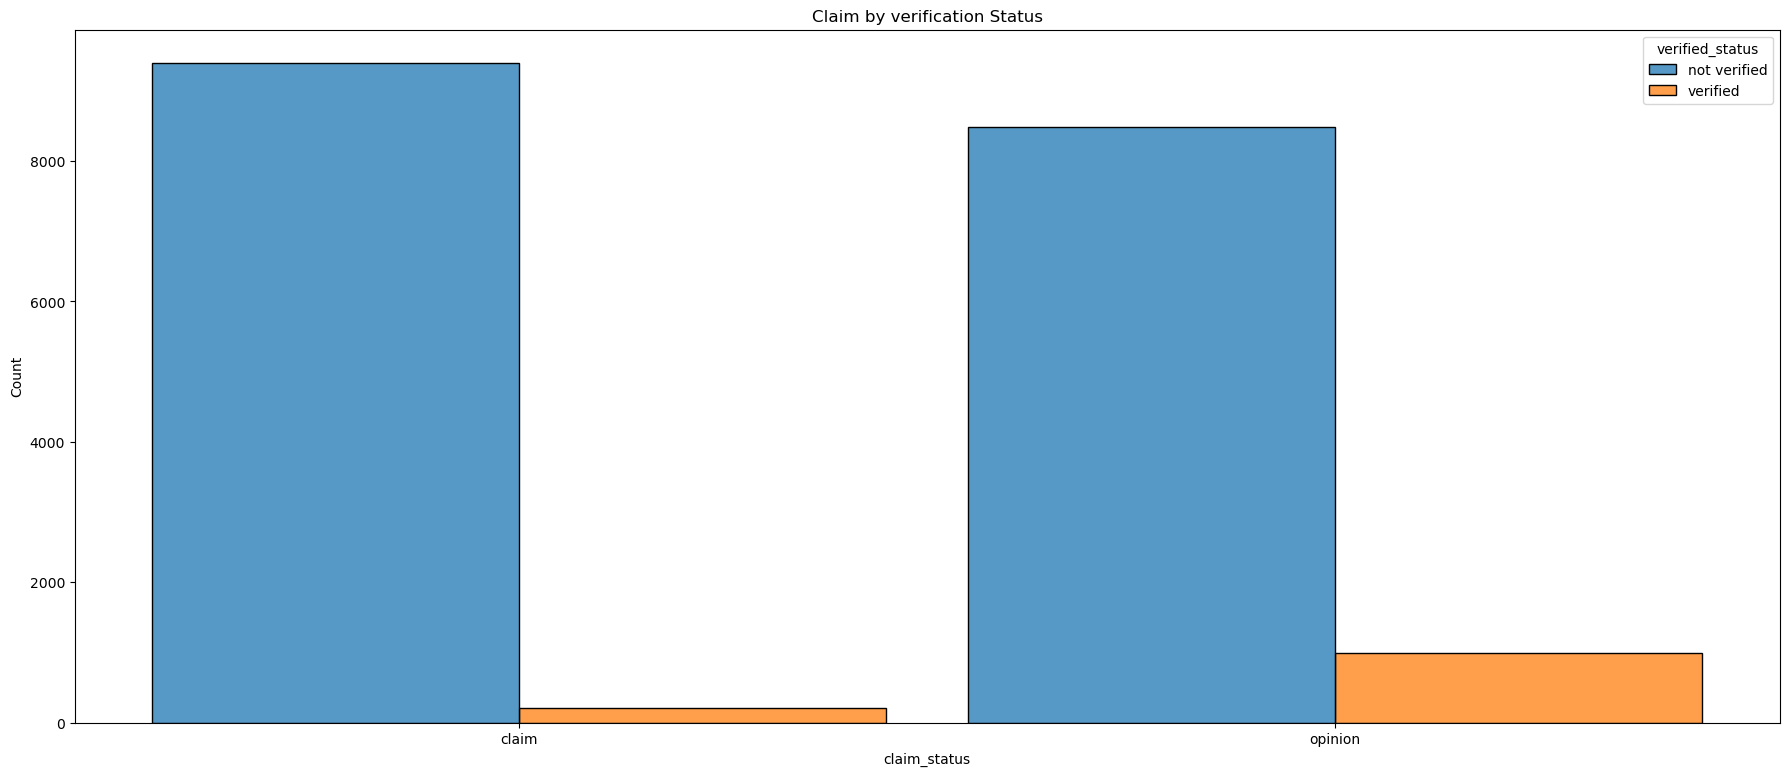

In [13]:
#Create a Histogram to visualize histogram between claim_status grouped by verified_status

plt.figure(figsize=(22,9))

sns.histplot(data=data,
            x='claim_status',
             hue='verified_status',
             multiple='dodge',
             shrink =0.9
            )

plt.title('Claim by verification Status')

Text(0.5, 1.0, 'Claims by author ban status')

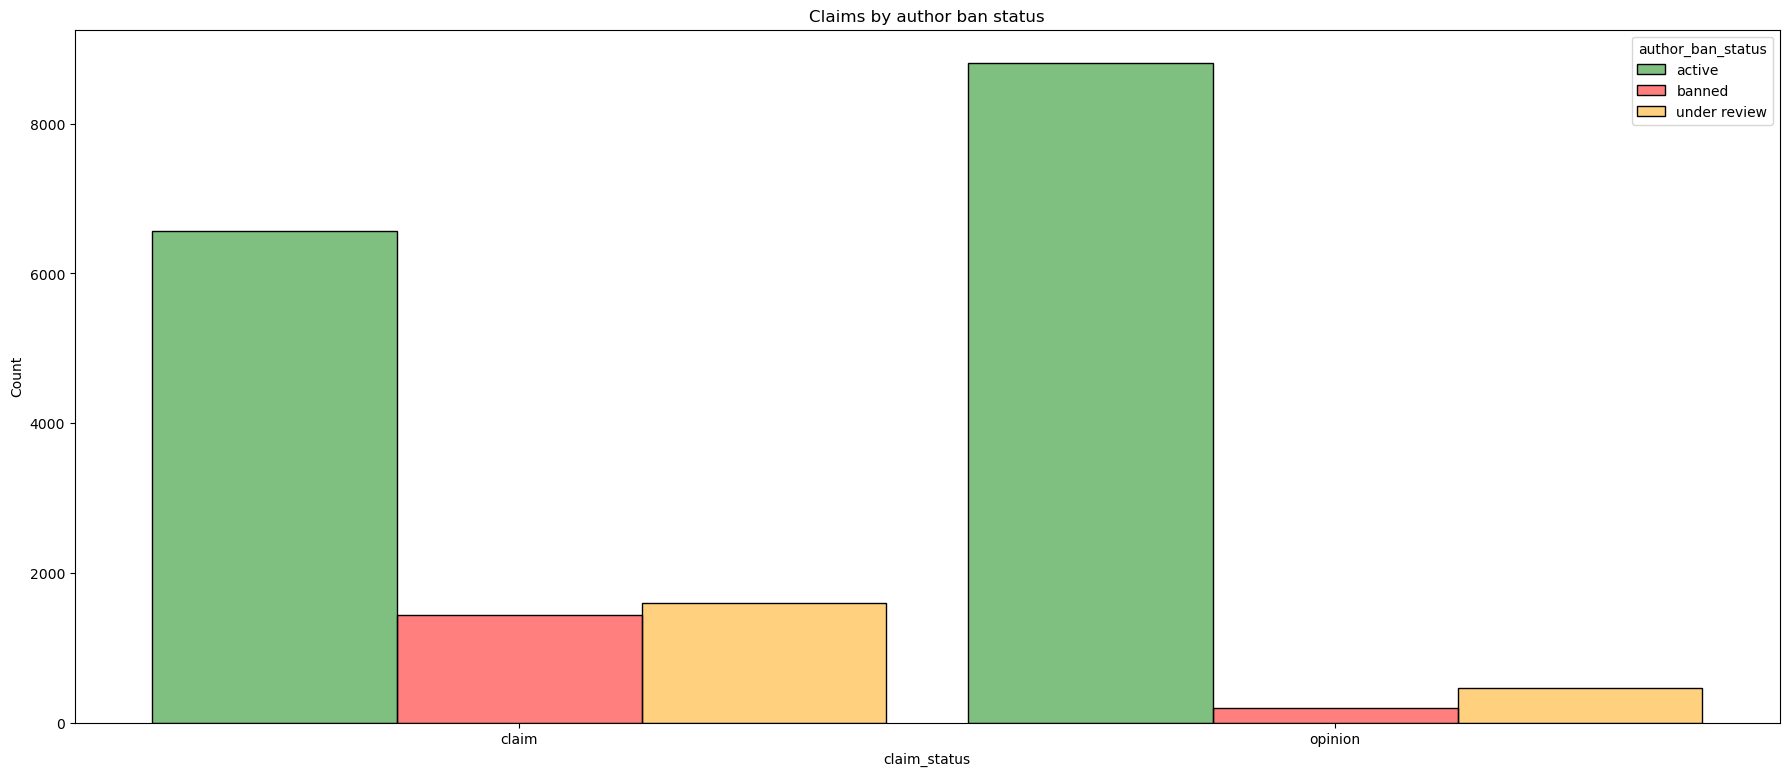

In [14]:
#Create a Histogram to visualize histogram between claim_status grouped by author_ban_status

plt.figure(figsize=(22,9))

sns.histplot(data=data, x='claim_status', hue='author_ban_status',
            multiple='dodge',
           hue_order =['active','banned','under review'],
            shrink=0.9,
            palette= {'active':'green','under review':'orange','banned':'red'},
            alpha=0.5
           )

plt.title('Claims by author ban status')

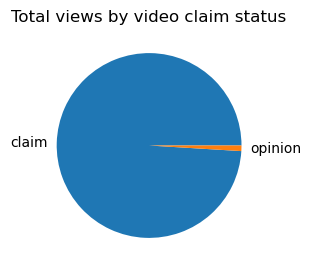

In [15]:
# use the pie chat video_view_count group by claim_status
fig = plt.figure(figsize=(3,3))
plt.pie(data.groupby('claim_status')['video_view_count'].sum(), labels=['claim', 'opinion'])
plt.title('Total views by video claim status');

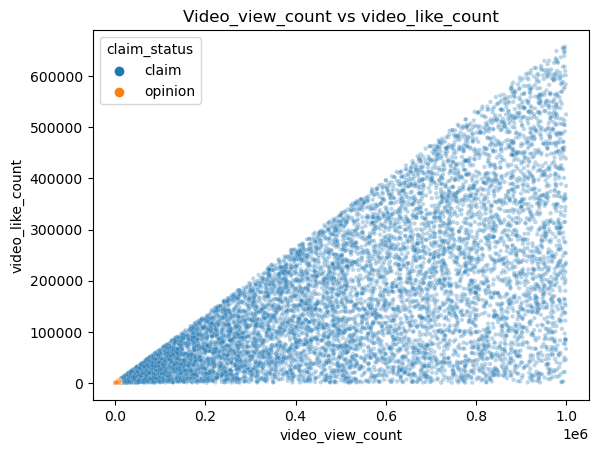

In [16]:
# check the relationship between video_view_count and video_like_count group by claim_status


sns.scatterplot(data=data, x='video_view_count', y='video_like_count',
               hue='claim_status', s=10, alpha= 0.3
               )

plt.title('Video_view_count vs video_like_count')

plt.show()

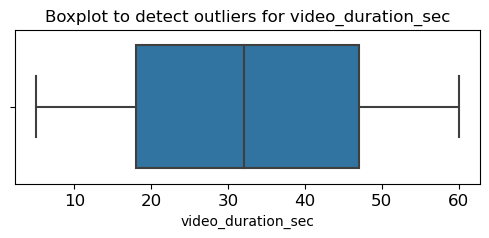

In [17]:
# Create a boxplot to visualize distribution of `video_duration_sec`
plt.figure(figsize=(6,2))
plt.title('Boxplot to detect outliers for video_duration_sec', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
sns.boxplot(x=data['video_duration_sec'])
plt.show()

We use visualization to see the outliers

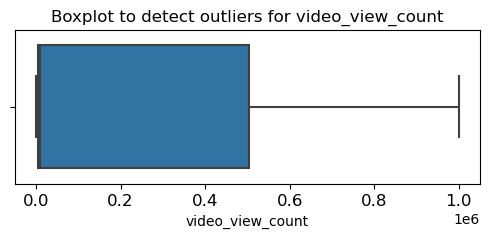

In [18]:
# Create a boxplot to visualize distribution of `video_view_count`
plt.figure(figsize=(6,2))
plt.title('Boxplot to detect outliers for video_view_count', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
sns.boxplot(x=data['video_view_count'])
plt.show()

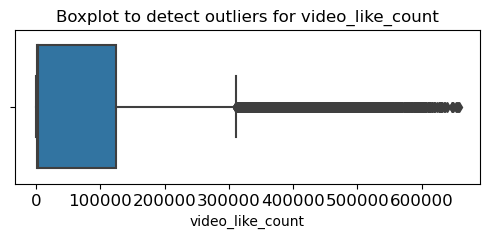

In [19]:
# Create a boxplot to visualize distribution of `video_like_count`
plt.figure(figsize=(6,2))
plt.title('Boxplot to detect outliers for video_like_count', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
sns.boxplot(x=data['video_like_count'])
plt.show()

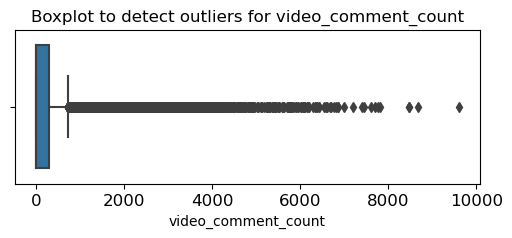

In [20]:
# Create a boxplot to visualize distribution of `video_comment_count`
plt.figure(figsize=(6,2))
plt.title('Boxplot to detect outliers for video_comment_count', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
sns.boxplot(x=data['video_comment_count'])
plt.show()

After Box plot we see, for the below columns outliers are visible.

    1. Video_like_count
    2.Video_comment_count
Now we have to remove those outliers.

In [21]:
def outlier_imputer(col_list,iqr_value):
   
    for col in col_list:
       #Reassign the values which is below zero
        data.loc[data[col]<0, col]=0
        
        #Set the iqr
        q3 = data[col].quantile(0.75)
        q1 = data[col].quantile(0.25)
        
        iqr = q3 - q1
        
        upper_thresold = q3 + (iqr_value*iqr)
        
        print('upperthresold' , upper_thresold)
        
        data.loc[data[col] > upper_thresold, col] = upper_thresold
        
        print(data[col].describe())
        

In [22]:
outlier_imputer(['video_like_count'] ,1.5 )

upperthresold 311333.875
count     19084.000000
mean      74323.538632
std      107103.555220
min           0.000000
25%         810.750000
50%        3403.500000
75%      125020.000000
max      311333.875000
Name: video_like_count, dtype: float64


In [23]:
outlier_imputer(['video_comment_count'] ,1.5 )

upperthresold 728.5
count    19084.000000
mean       181.023501
std        272.084766
min          0.000000
25%          1.000000
50%          9.000000
75%        292.000000
max        728.500000
Name: video_comment_count, dtype: float64


# Check Class Balance

In [24]:
data['verified_status'].value_counts(normalize= True)

not verified    0.93712
verified        0.06288
Name: verified_status, dtype: float64

Approximately 94% of dataset represents videos posted by unverified accounts and 6% represent videos posted by verfied accounts. So the outcome variables is not very balanced.

# Use Resampling to create class balace

In [25]:
# Use resampling to create class balance in the outcome variable, if needed

# Identify data points from majority and minority classes
data_majority = data[data['verified_status']=='not verified']
data_minority = data[data['verified_status']=='verified']

#Upsampled the minority class(which is verified)

data_minority_upsampled = resample(
                            data_minority,
                            replace=True, # to sample with replacement   
                            n_samples = len(data_majority),  # to match majority class
                            random_state=0
                        )
# Combine majority class with upsampled minority class
data_upsampled = pd.concat([data_majority,data_minority_upsampled]).reset_index(drop=True)

data_upsampled['verified_status'].value_counts()

not verified    17884
verified        17884
Name: verified_status, dtype: int64

We have to check the avg length of video_transcription text for verified and not verified customer in new dataset

In [26]:
data_upsampled[['verified_status','video_transcription_text']].groupby(by='verified_status')[['video_transcription_text']].agg(func=lambda array: np.mean([len(text) for text in array]))

,video_transcription_text
verified_status,
not verified,89.061116
verified,84.439163


As we see, text length is more or less same for both verified and not verified user after resampling.

# Feature Enginnering

Create a column text_length which store length of video_transcription_text for each post

In [27]:
data_upsampled['text_length'] = data_upsampled['video_transcription_text'].str.len()

In [28]:
data_upsampled['text_length'].head()

0     97
1    107
2    137
3    131
4    128
Name: text_length, dtype: int64

We need to check word count for verified and unverified columns

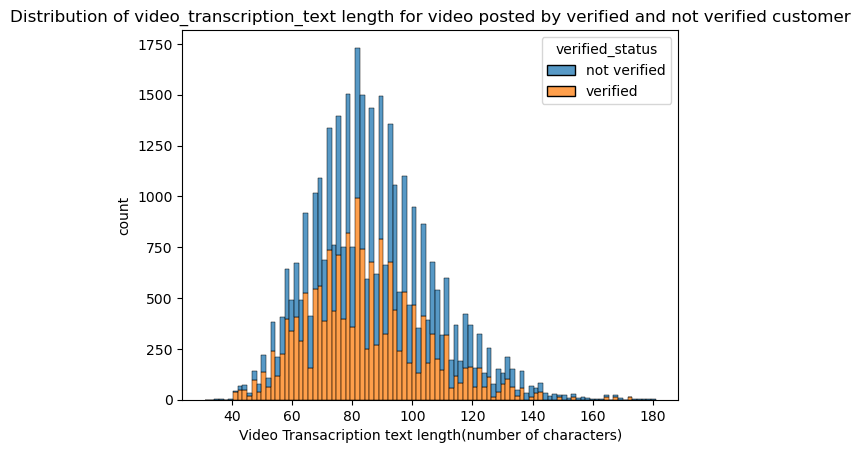

In [29]:
sns.histplot(data=data_upsampled, stat='count',multiple='stack', x='text_length',
            kde=False, hue='verified_status',element='bars',legend= True)

plt.xlabel('Video Transacription text length(number of characters)')
plt.ylabel('count')
plt.title('Distribution of video_transcription_text length for video posted by verified and not verified customer')
plt.show()

# Examine Correlations between columns.

In [30]:
data_upsampled.corr()

,#,video_id,video_duration_sec,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count,text_length
#,1.000000,-0.000853,-0.011729,-0.697007,-0.626385,-0.504015,-0.487096,-0.608773,-0.183312
video_id,-0.000853,1.000000,0.011859,0.002554,0.005993,0.010515,0.008753,0.012674,-0.007260
video_duration_sec,-0.011729,0.011859,1.000000,0.013589,0.004494,0.002206,0.003989,-0.001086,-0.003171
video_view_count,-0.697007,0.002554,0.013589,1.000000,0.856937,0.711313,0.690048,0.748361,0.234807
video_like_count,-0.626385,0.005993,0.004494,0.856937,1.000000,0.832146,0.805543,0.818032,0.207730
video_share_count,-0.504015,0.010515,0.002206,0.711313,0.832146,1.000000,0.710117,0.671335,0.164664
video_download_count,-0.487096,0.008753,0.003989,0.690048,0.805543,0.710117,1.000000,0.793668,0.166529
video_comment_count,-0.608773,0.012674,-0.001086,0.748361,0.818032,0.671335,0.793668,1.000000,0.209064
text_length,-0.183312,-0.007260,-0.003171,0.234807,0.207730,0.164664,0.166529,0.209064,1.000000


Create a heatmap to show the correaltion visualy.

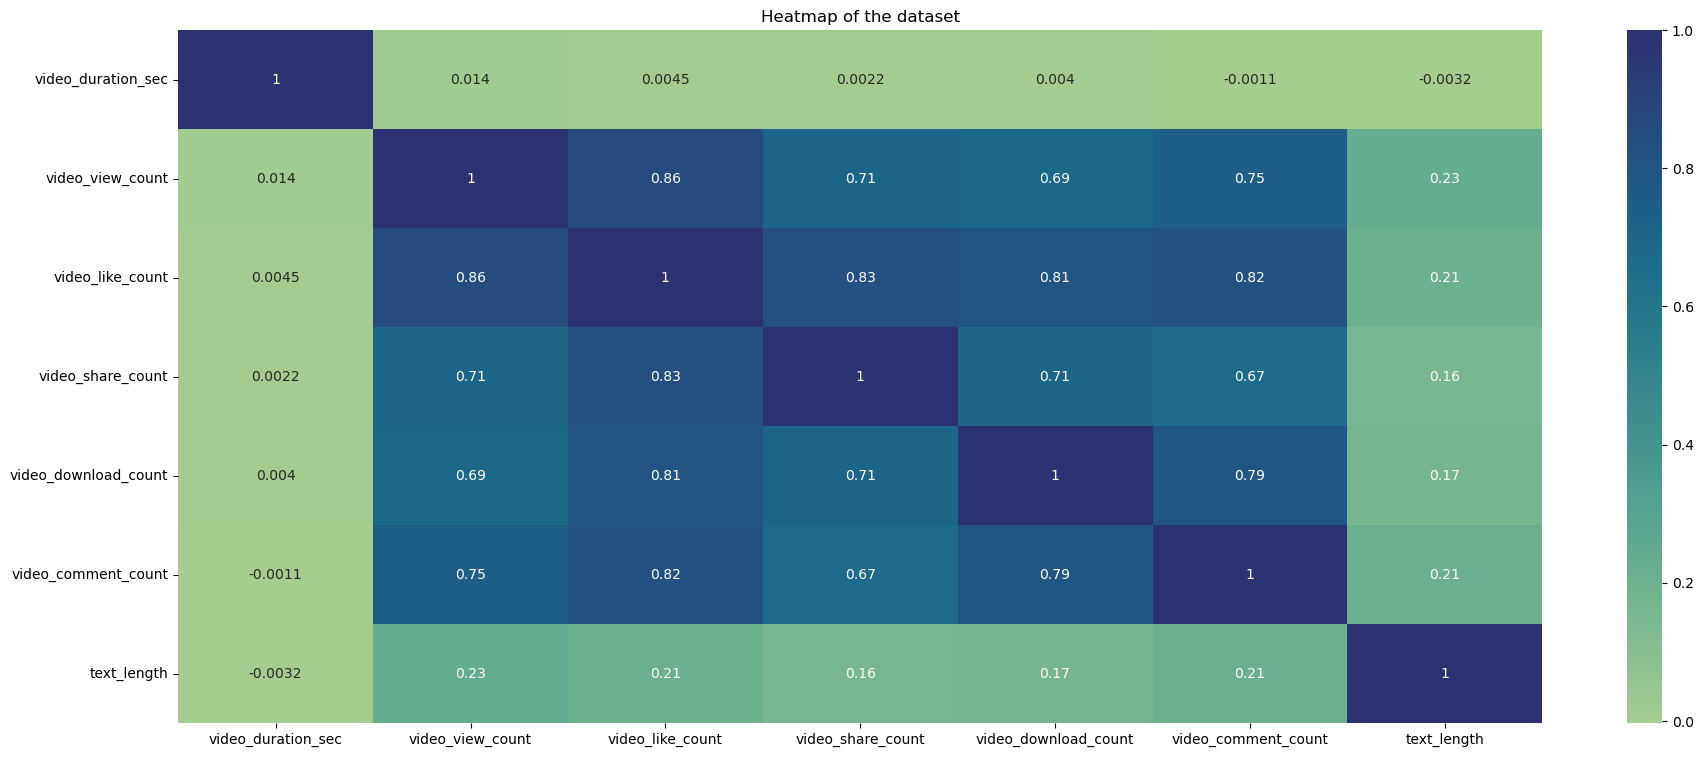

In [31]:
plt.figure(figsize=(22,9))

sns.heatmap(data =data_upsampled[['video_duration_sec','video_view_count','video_like_count',
                                 'video_share_count','video_download_count','video_comment_count',
                                 'text_length','claim_status','author_ban_status']].corr(), annot=True, cmap='crest')

plt.title('Heatmap of the dataset')
plt.show()

The above heatmap shows that the following pair of variables are strongly correlated  : Video_view_count and video_like_count(0.86)

One of the logistic regression model assumption is no severe multicolinearity among the feature. so for creation logistic regression model, we have to exclude any of video_view_count and video_like_count.

I exclude video_like_count columns.

# Select variables for model

In [38]:
y= data_upsampled[['verified_status']]

X = data_upsampled[["video_duration_sec", "claim_status", "author_ban_status", "video_view_count", "video_share_count", "video_download_count", "video_comment_count"]]

X.head()

,video_duration_sec,claim_status,author_ban_status,video_view_count,video_share_count,video_download_count,video_comment_count
0,59,claim,under review,343296.0,241.0,1.0,0.0
1,32,claim,active,140877.0,19034.0,1161.0,684.0
2,31,claim,active,902185.0,2858.0,833.0,329.0
3,25,claim,active,437506.0,34812.0,1234.0,584.0
4,19,claim,active,56167.0,4110.0,547.0,152.0


# Change variable type to fit in the model

In [39]:
X.dtypes

video_duration_sec        int64
claim_status             object
author_ban_status        object
video_view_count        float64
video_share_count       float64
video_download_count    float64
video_comment_count     float64
dtype: object

As we see in the above, claim_status, author_ban_status and verified_status is object type and to fit the model we have to change the data type int so we use onehot encoding

In [40]:
X['claim_status'] = X['claim_status'].replace({'claim':1,'opinion':0})

C:\Users\Chinmoy Hazra\AppData\Local\Temp\ipykernel_19128\2612203909.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['claim_status'] = X['claim_status'].replace({'claim':1,'opinion':0})


In [41]:
y['verified_status'] =y['verified_status'].map({'verified': 1, 'not verified':0})

C:\Users\Chinmoy Hazra\AppData\Local\Temp\ipykernel_19128\346549153.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y['verified_status'] =y['verified_status'].map({'verified': 1, 'not verified':0})


In [42]:
X = pd.get_dummies(X, columns=['author_ban_status'],drop_first=True)

X.head()

,video_duration_sec,claim_status,video_view_count,video_share_count,video_download_count,video_comment_count,author_ban_status_banned,author_ban_status_under review
0,59,1,343296.0,241.0,1.0,0.0,0,1
1,32,1,140877.0,19034.0,1161.0,684.0,0,0
2,31,1,902185.0,2858.0,833.0,329.0,0,0
3,25,1,437506.0,34812.0,1234.0,584.0,0,0
4,19,1,56167.0,4110.0,547.0,152.0,0,0


Split the dataset into train and test for regression modeling

In [43]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

# Build the Regression Model

In [44]:
# Construct a logistic regression model and fit it to the training set
log_clf = LogisticRegression(random_state=0, max_iter=800).fit(X_train, y_train)

C:\Users\Chinmoy Hazra\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


# Build the Regression Model

# Build the Regression Model

In [45]:
y_pred = log_clf.predict(X_test)

# Visualize model results

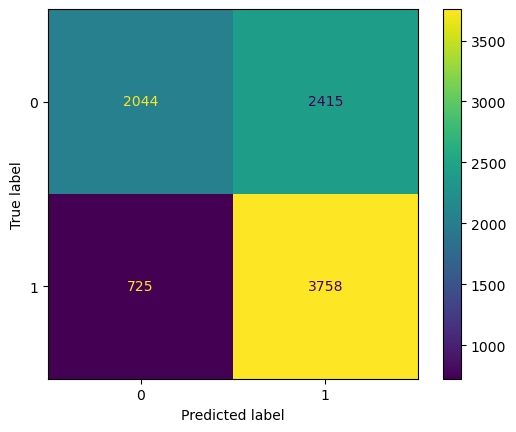

In [46]:
# Compute values for confusion matrix
log_cm = confusion_matrix(y_test, y_pred, labels=log_clf.classes_)

# Create display of confusion matrix
log_disp = ConfusionMatrixDisplay(confusion_matrix=log_cm, display_labels=log_clf.classes_)

# Plot confusion matrix
log_disp.plot()

# Display plot
plt.show()

As we see in confusion matrix

True Positive(lower-right and correctly identified by model)=3758
True Negative(upper-left and correctly identified by model) = 2044
False Postive(upper-right and incorrectly identified by model) =3758
False Negative(lower-left and incorrectly identified by model) =725

Now we will create classification report to check other values


In [47]:
# Create classification report for logistic regression model
target_labels = ["verified", "not verified"]
print(classification_report(y_test, y_pred, target_names=target_labels))

              precision    recall  f1-score   support

    verified       0.74      0.46      0.57      4459
not verified       0.61      0.84      0.71      4483

    accuracy                           0.65      8942
   macro avg       0.67      0.65      0.64      8942
weighted avg       0.67      0.65      0.64      8942



In [48]:
# Get the feature names from the model and the model coefficients (which represent log-odds ratios)
# Place into a DataFrame for readability
pd.DataFrame(data={"Feature Name":log_clf.feature_names_in_, "Model Coefficient":log_clf.coef_[0]})

,Feature Name,Model Coefficient
0,video_duration_sec,8.610043e-03
1,claim_status,-9.458306e-05
2,video_view_count,-2.131877e-06
3,video_share_count,5.930941e-06
4,video_download_count,-1.100267e-05
5,video_comment_count,-6.406098e-04
6,author_ban_status_banned,-1.782010e-05
7,author_ban_status_under review,-9.673756e-07


# Use Machine learning model to predict claim or opinion

Previously we use Logistic Regression model to predict claim and opinion using target variable verified_status but now we use machine learning model and changing target variable as claim_status and try to find claim and opinion

In [49]:
data.head()

,#,claim_status,video_id,video_duration_sec,video_transcription_text,verified_status,author_ban_status,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count
0,1,claim,7017666017,59,someone shared with me that drone deliveries a...,not verified,under review,343296.0,19425.0,241.0,1.0,0.0
1,2,claim,4014381136,32,someone shared with me that there are more mic...,not verified,active,140877.0,77355.0,19034.0,1161.0,684.0
2,3,claim,9859838091,31,someone shared with me that american industria...,not verified,active,902185.0,97690.0,2858.0,833.0,329.0
3,4,claim,1866847991,25,someone shared with me that the metro of st. p...,not verified,active,437506.0,239954.0,34812.0,1234.0,584.0
4,5,claim,7105231098,19,someone shared with me that the number of busi...,not verified,active,56167.0,34987.0,4110.0,547.0,152.0


In [50]:
data['text_length']= data['video_transcription_text'].str.len()

In [51]:
X = data.copy()

In [52]:
X.shape

(19084, 13)

In [53]:
X.head()

,#,claim_status,video_id,video_duration_sec,video_transcription_text,verified_status,author_ban_status,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count,text_length
0,1,claim,7017666017,59,someone shared with me that drone deliveries a...,not verified,under review,343296.0,19425.0,241.0,1.0,0.0,97
1,2,claim,4014381136,32,someone shared with me that there are more mic...,not verified,active,140877.0,77355.0,19034.0,1161.0,684.0,107
2,3,claim,9859838091,31,someone shared with me that american industria...,not verified,active,902185.0,97690.0,2858.0,833.0,329.0,137
3,4,claim,1866847991,25,someone shared with me that the metro of st. p...,not verified,active,437506.0,239954.0,34812.0,1234.0,584.0,131
4,5,claim,7105231098,19,someone shared with me that the number of busi...,not verified,active,56167.0,34987.0,4110.0,547.0,152.0,128


# Use hotendcoding for X and Y variables

In [54]:
#drop the less important columns and tag

X = X.drop(['#','video_id'], axis=1)


In [55]:
X['claim_status'] = X['claim_status'].map({'claim' : 1, 'opinion':0})

X['claim_status'].head()

0    1
1    1
2    1
3    1
4    1
Name: claim_status, dtype: int64

In [56]:
X['claim_status'].unique()

array([1, 0], dtype=int64)

In [57]:
X = pd.get_dummies(X,columns=['author_ban_status','verified_status'], drop_first=True)
X.head()

,claim_status,video_duration_sec,video_transcription_text,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count,text_length,author_ban_status_banned,author_ban_status_under review,verified_status_verified
0,1,59,someone shared with me that drone deliveries a...,343296.0,19425.0,241.0,1.0,0.0,97,0,1,0
1,1,32,someone shared with me that there are more mic...,140877.0,77355.0,19034.0,1161.0,684.0,107,0,0,0
2,1,31,someone shared with me that american industria...,902185.0,97690.0,2858.0,833.0,329.0,137,0,0,0
3,1,25,someone shared with me that the metro of st. p...,437506.0,239954.0,34812.0,1234.0,584.0,131,0,0,0
4,1,19,someone shared with me that the number of busi...,56167.0,34987.0,4110.0,547.0,152.0,128,0,0,0


In [58]:
y = X['claim_status']

In [59]:
X = X.drop(columns='claim_status',axis=1)

Now we split the data into three part. Train, test and validation.

Train and validation is used for testing two mechine learning models and after that model which will perform better will be used for final test data.

In [60]:
# Split the data into training and testing sets
X_tr,X_test , y_tr,y_test = train_test_split(X,y,stratify=y,test_size=0.2, random_state=42)

In [61]:
# Split the training data into training and validation sets
X_train,X_val,y_train,y_val = train_test_split(X_tr,y_tr,test_size=0.25,stratify=y_tr,random_state=42)

For Check dataset is distributed in train,test and validation as we wanted.

In [62]:
# Get shape of each training, validation, and testing set
X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape

((11450, 11), (3817, 11), (3817, 11), (11450,), (3817,), (3817,))

# Tokenize text colum or NLP

The feature of video_transcription_text is text-based. It is not a categorical variable, since it does not have a fixed number of possible values.

Obe way to extract numerical features from it is though a bag-of-words algorithm like countvertorizer.

CountVectorizer works by splitting text into n-grams, which are group of n consecutive words and stored in a count matrix. After the count matrix has been created, then it choose the most frequently occuring n-grams and we specify how many feature can be used in a model.

In [63]:
# Set up a `CountVectorizer` object, which converts a collection of text to a matrix of token counts
count_vec = CountVectorizer(ngram_range =(2,3), max_features =15,stop_words='english')

count_vec


CountVectorizer(max_features=15, ngram_range=(2, 3), stop_words='english')

In [64]:
# Extract numerical features from `video_transcription_text` in the training set
count_data = count_vec.fit_transform(X_train['video_transcription_text']).toarray()

count_data

array([[0, 0, 0, ..., 0, 0, 0],
       [1, 0, 1, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [65]:
# Place the numerical representation of `video_transcription_text` from training set into a dataframe
count_df = pd.DataFrame(data= count_data, columns= count_vec.get_feature_names_out())

In [66]:
count_df.head()

,colleague learned,colleague read,discussion board,friend learned,friend read,internet forum,learned media,learned news,learned website,media claim,news claim,point view,read media,social media,willing wager
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [67]:
#Concatenate `X_train` and `count_df` to form the final dataframe for training data (`X_train_final`)

X_train_final = pd.concat([X_train.drop(columns=['video_transcription_text']).reset_index(drop=True), count_df], axis=1)


In [68]:
X_train_final.head()

,video_duration_sec,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count,text_length,author_ban_status_banned,author_ban_status_under review,verified_status_verified,...,internet forum,learned media,learned news,learned website,media claim,news claim,point view,read media,social media,willing wager
0,41,749.0,258.0,26.0,1.0,0.0,80,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,54,509786.0,71132.0,730.0,72.0,9.0,105,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,57,9514.0,1137.0,205.0,14.0,1.0,60,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,10,6656.0,1181.0,158.0,18.0,3.0,84,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,30,90131.0,44618.0,13132.0,439.0,121.0,108,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [69]:
# Extract numerical features from `video_transcription_text` in the testing set
validation_count_data = count_vec.transform(X_val['video_transcription_text']).toarray()
validation_count_data


array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [70]:
# Place the numerical representation of `video_transcription_text` from validation set into a dataframe
validation_count_df = pd.DataFrame(data=validation_count_data, columns=count_vec.get_feature_names_out())
validation_count_df.head()


,colleague learned,colleague read,discussion board,friend learned,friend read,internet forum,learned media,learned news,learned website,media claim,news claim,point view,read media,social media,willing wager
0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [71]:
# Concatenate `X_val` and `validation_count_df` to form the final dataframe for training data (`X_val_final`)
X_val_final = pd.concat([X_val.drop(columns=['video_transcription_text']).reset_index(drop=True), validation_count_df], axis=1)

# Display first few rows
X_val_final.head()

,video_duration_sec,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count,text_length,author_ban_status_banned,author_ban_status_under review,verified_status_verified,...,internet forum,learned media,learned news,learned website,media claim,news claim,point view,read media,social media,willing wager
0,20,203987.0,90121.000,35657.0,120.0,62.0,85,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,37,428015.0,29985.000,11696.0,260.0,126.0,108,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,18,667562.0,311333.875,18435.0,7778.0,728.5,66,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,30,1722.0,249.000,98.0,3.0,1.0,79,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,56,5598.0,729.000,13.0,2.0,1.0,68,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [72]:
# Extract numerical features from `video_transcription_text` in the testing set
test_count_data = count_vec.transform(X_test['video_transcription_text']).toarray()

# Place the numerical representation of `video_transcription_text` from test set into a dataframe
test_count_df = pd.DataFrame(data=test_count_data, columns=count_vec.get_feature_names_out())


In [73]:

# Concatenate `X_val` and `validation_count_df` to form the final dataframe for training data (`X_val_final`)
X_test_final = pd.concat([X_test.drop(columns=['video_transcription_text']
                                      ).reset_index(drop=True), test_count_df], axis=1)
X_test_final.head()


,video_duration_sec,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count,text_length,author_ban_status_banned,author_ban_status_under review,verified_status_verified,...,internet forum,learned media,learned news,learned website,media claim,news claim,point view,read media,social media,willing wager
0,41,193290.0,91859.000,10513.0,878.0,321.0,92,0,0,0,...,0,0,0,0,1,0,0,1,0,0
1,7,4972.0,639.000,249.0,5.0,1.0,95,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,45,46288.0,24249.000,2208.0,182.0,56.0,95,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,23,9728.0,2713.000,818.0,34.0,6.0,85,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,42,938468.0,311333.875,19682.0,871.0,27.0,129,0,0,0,...,0,0,0,1,0,0,0,0,0,0


# Use Random Forest 

In [74]:
# Instantiate the random forest classifier
rf = RandomForestClassifier(random_state=0)

# Create a dictionary of hyperparameters to tune
cv_params = {'max_depth': [5, 7, None],
             'max_features': [0.3, 0.6],
            #  'max_features': 'auto'
             'max_samples': [0.7],
             'min_samples_leaf': [1,2],
             'min_samples_split': [2,3],
             'n_estimators': [75,100,200],
             }

# Define a dictionary of scoring metrics to capture
scoring = {'accuracy', 'precision', 'recall', 'f1'}


In [75]:
# Instantiate the GridSearchCV object
rf_cv = GridSearchCV(rf, cv_params, scoring=scoring, cv=5, refit='recall')


In [76]:
%%time
rf_cv.fit(X_train_final, y_train)


Wall time: 4min 47s


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=0),
             param_grid={'max_depth': [5, 7, None], 'max_features': [0.3, 0.6],
                         'max_samples': [0.7], 'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 3],
                         'n_estimators': [75, 100, 200]},
             refit='recall', scoring={'precision', 'f1', 'recall', 'accuracy'})

Evalute and Find the best paramets

In [77]:
# Examine best recall score
rf_cv.best_score_


0.9947952804278692

In [78]:
# Examine best parameters
rf_cv.best_params_


{'max_depth': None,
 'max_features': 0.3,
 'max_samples': 0.7,
 'min_samples_leaf': 1,
 'min_samples_split': 3,
 'n_estimators': 75}

In [79]:
#test the model in validation data
# Use the random forest "best estimator" model to get predictions on the validation set
y_pred = rf_cv.best_estimator_.predict(X_val_final)


In [80]:
#find the best estimators
rf_cv.best_estimator_

RandomForestClassifier(max_features=0.3, max_samples=0.7, min_samples_split=3,
                       n_estimators=75, random_state=0)

In [81]:
# Display the predictions on the validation set
y_pred


array([1, 1, 1, ..., 1, 1, 1], dtype=int64)

In [165]:
#Display the true labels of the validation set
y_val


5846     1
12058    0
2975     1
8432     1
6863     1
        ..
6036     1
6544     1
2781     1
6426     1
4450     1
Name: claim_status, Length: 3817, dtype: int64

Create a confusion matrix to visualize the results of the classification model

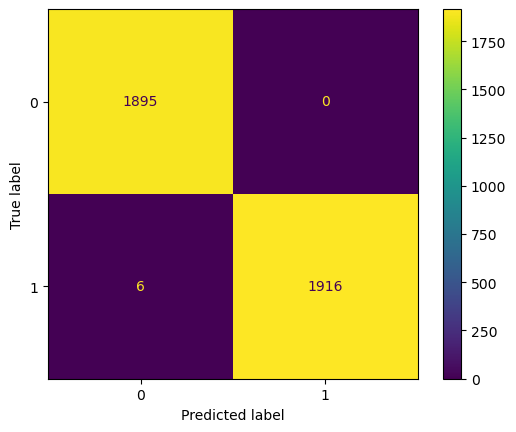

In [82]:

# Compute values for confusion matrix
log_cm = confusion_matrix(y_val, y_pred)

# Create display of confusion matrix
log_disp = ConfusionMatrixDisplay(confusion_matrix=log_cm, display_labels=None)

# Plot confusion matrix
log_disp.plot()

# Display plot
plt.show()



In [83]:
# Create a classification report
# Create classification report for random forest model
target_labels = ['opinion', 'claim']
print(classification_report(y_val, y_pred, target_names=target_labels))


              precision    recall  f1-score   support

     opinion       1.00      1.00      1.00      1895
       claim       1.00      1.00      1.00      1922

    accuracy                           1.00      3817
   macro avg       1.00      1.00      1.00      3817
weighted avg       1.00      1.00      1.00      3817



Create a function to store the values

In [84]:
# Get all the results from the CV and put them in a df
### YOUR CODE HERE ###

def make_result(model_name,model_object):
    
    cv_result = pd.DataFrame(model_object.cv_results_)
    
    best_estimator_result = cv_result.iloc[cv_result['mean_test_precision'].idxmax(), :]
    
    f1 = best_estimator_result.mean_test_f1
    recall = best_estimator_result.mean_test_recall
    precision = best_estimator_result.mean_test_precision
    accuracy = best_estimator_result.mean_test_accuracy
    
    
    
    
    table = pd.DataFrame().append({
      'Model_name' : model_name,  
        'f1' :f1,
        'recall' :recall,
        'precision' :precision,
        'accuracy' : accuracy
        
    },
        ignore_index=True
    
    )
    return table


In [95]:
results_rf = make_result('RandomForest',rf_cv)

results_rf

C:\Users\Chinmoy Hazra\AppData\Local\Temp\ipykernel_19128\2861694737.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table = pd.DataFrame().append({


,Model_name,f1,recall,precision,accuracy
0,RandomForest,0.995464,0.990978,1.0,0.995459


# Use XGBoost

In [86]:
# Instantiate the XGBoost classifier
xgb = XGBClassifier(objective='binary:logistic', random_state=0)

# Create a dictionary of hyperparameters to tune
cv_params = {'max_depth': [4,8,12],
             'min_child_weight': [3, 5],
             'learning_rate': [0.01, 0.1],
             'n_estimators': [300, 500]
             }

# Define a dictionary of scoring metrics to capture
scoring = {'accuracy', 'precision', 'recall', 'f1'}


In [87]:

# Instantiate the GridSearchCV object
xgb_cv = GridSearchCV(xgb, cv_params, scoring=scoring, cv=5, refit='recall')


In [88]:
%%time
xgb_cv.fit(X_train_final, y_train)


Wall time: 3min 39s


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                   

Evalute and find best parameters

In [89]:
#find the best score
xgb_cv.best_score_

0.9895905608557387

In [90]:
#find the best score
xgb_cv.best_params_

{'learning_rate': 0.01,
 'max_depth': 4,
 'min_child_weight': 3,
 'n_estimators': 300}

In [91]:
#Evaluate XGBoost model
y_pred = xgb_cv.best_estimator_.predict(X_val_final)


Create a confusion matrix to visualize the results of the classification model

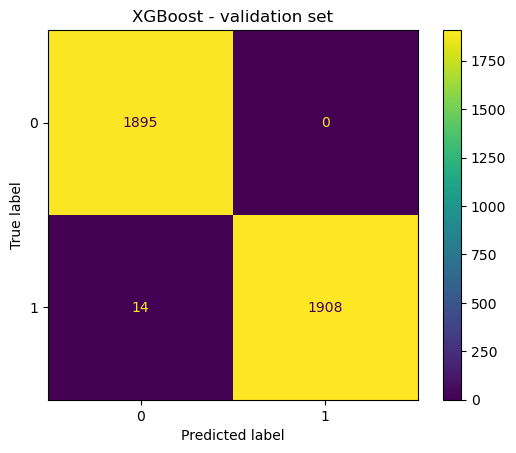

In [92]:
# Compute values for confusion matrix
log_cm = confusion_matrix(y_val, y_pred)

# Create display of confusion matrix
log_disp = ConfusionMatrixDisplay(confusion_matrix=log_cm, display_labels=None)

# Plot confusion matrix
log_disp.plot()

# Display plot
plt.title('XGBoost - validation set');
plt.show()


In [93]:
# Create a classification report
target_labels = ['opinion', 'claim']
print(classification_report(y_val, y_pred, target_names=target_labels))


              precision    recall  f1-score   support

     opinion       0.99      1.00      1.00      1895
       claim       1.00      0.99      1.00      1922

    accuracy                           1.00      3817
   macro avg       1.00      1.00      1.00      3817
weighted avg       1.00      1.00      1.00      3817



In [96]:
results_xgb = make_result('XGBoost',xgb_cv)

results_xgb

C:\Users\Chinmoy Hazra\AppData\Local\Temp\ipykernel_19128\2861694737.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table = pd.DataFrame().append({


,Model_name,f1,recall,precision,accuracy
0,XGBoost,0.994677,0.989417,1.0,0.994672


In [98]:
#create a singular dataframe for both results

results = pd.concat([results_rf,results_xgb], axis=0)

results

,Model_name,f1,recall,precision,accuracy
0,RandomForest,0.995464,0.990978,1.0,0.995459
0,XGBoost,0.994677,0.989417,1.0,0.994672


The results of the XGBoost model were also nearly perfect. However, its errors tended to be false negatives. Identifying claims was the priority, so it's important that the model be good at capturing all actual claim videos. The random forest model has a better recall score, and is therefore the champion model.

# Use Champoin model for test data

In [101]:
# Use champion model to predict on test data
y_pred = rf_cv.best_estimator_.predict(X_test_final)


Create a confusion matrix for visualizations.


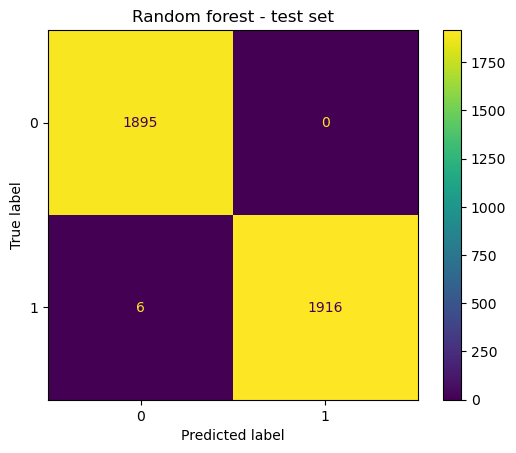

In [102]:
# Compute values for confusion matrix
log_cm = confusion_matrix(y_test, y_pred)
# Create display of confusion matrix
log_disp = ConfusionMatrixDisplay(confusion_matrix=log_cm, display_labels=None)

# Plot confusion matrix
log_disp.plot()

# Display plot
plt.title('Random forest - test set');
plt.show()

Feature importances of champion model

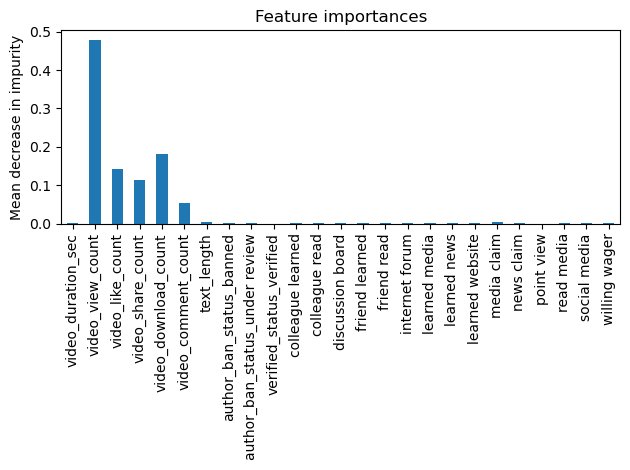

In [103]:
importances = rf_cv.best_estimator_.feature_importances_
rf_importances = pd.Series(importances, index=X_test_final.columns)

fig, ax = plt.subplots()
rf_importances.plot.bar(ax=ax)
ax.set_title('Feature importances')
ax.set_ylabel('Mean decrease in impurity')
fig.tight_layout()
